# Computing Sentiment analysis on each tweet
----
Using the Module "TextBlob", we firstly calculate the sentiment of a given text where the value ranges form value ranges from -1 (very negative) to +1 (very positive).

In [198]:
import pandas as pd
from textblob import TextBlob
from datetime import datetime
import chardet   

# Function to calculate sentiment using TextBlob
def calculate_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

data = pd.read_csv('tweets_2016_2019.csv', encoding = "UTF-16")

# Convert 'created_at' to datetime
data['created_at'] = pd.to_datetime(data['created_at'], format='%m-%d-%Y %H:%M:%S')


# Calculate sentiment for each text
sentiments = []
for text in data['text']:
    sentiment = calculate_sentiment(text)
    sentiments.append(sentiment)

# Append the sentiment scores as a new column
data['sentiment'] = sentiments

data.head()


,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str,sentiment
0,Twitter for iPhone,Our prayers are with the families of the victi...,2019-12-31 00:57:13,39706,191167,False,1211813523581546496,0.600000
1,Twitter for iPhone,RT @realDonaldTrump: https://t.co/Mn4EJ7Jbh8,2019-12-31 00:00:34,40917,0,True,1211799266974478337,0.000000
2,Twitter for iPhone,RT @BreitbartNews: This Christmas let the impe...,2019-12-30 22:23:36,6012,0,True,1211774864362737665,0.000000
3,Twitter for iPhone,He is Fake News will always be Fredo to us. I ...,2019-12-30 22:23:04,20037,81302,False,1211774730258264066,-0.558333
4,Twitter for iPhone,Thank you to highly respected Jewish leader Do...,2019-12-30 14:28:26,21588,112303,False,1211655287247126535,0.386667


### Calculating percentage of positive (sentiment > 0) negative (sentiment < 0) neutral (sentiment = 0) tweets
---


In [199]:
# Calculate the counts of positive, negative, and neutral tweets
positive_tweets = data[data['sentiment'] > 0]
negative_tweets = data[data['sentiment'] < 0]
neutral_tweets = data[data['sentiment'] == 0]

# Calculate the percentages
total_tweets = len(data)
positive_percentage = len(positive_tweets) / total_tweets * 100
negative_percentage = len(negative_tweets) / total_tweets * 100
neutral_percentage = len(neutral_tweets) / total_tweets * 100

print("Percentage of positive tweets:", positive_percentage)
print("Percentage of negative tweets:", negative_percentage)
print("Percentage of neutral tweets:", neutral_percentage)

Percentage of positive tweets: 51.32355420671051
Percentage of negative tweets: 21.44101612993874
Percentage of neutral tweets: 27.235429663350757


Looking at the above result, it is clear that the tweets over time from 2016 to 2019 were mostly positve in sentiment according

### Computing daily average of sentiment
---

In [200]:
# Convert 'created_at' to datetime
data['created_at'] = pd.to_datetime(data['created_at'])

# Extract date from 'created_at' column
data['date'] = data['created_at'].dt.date

# Group by date and calculate daily average sentiment
daily_average_sentiment = data.groupby('date')['sentiment'].mean().reset_index()

# Display the new dataframe
print(daily_average_sentiment.head())

vix = pd.read_excel('VIX_futures_2016_2019.xlsx')

         date  sentiment
0  2016-01-01   0.315730
1  2016-01-02   0.036553
2  2016-01-03   0.100184
3  2016-01-04   0.415625
4  2016-01-05   0.363826


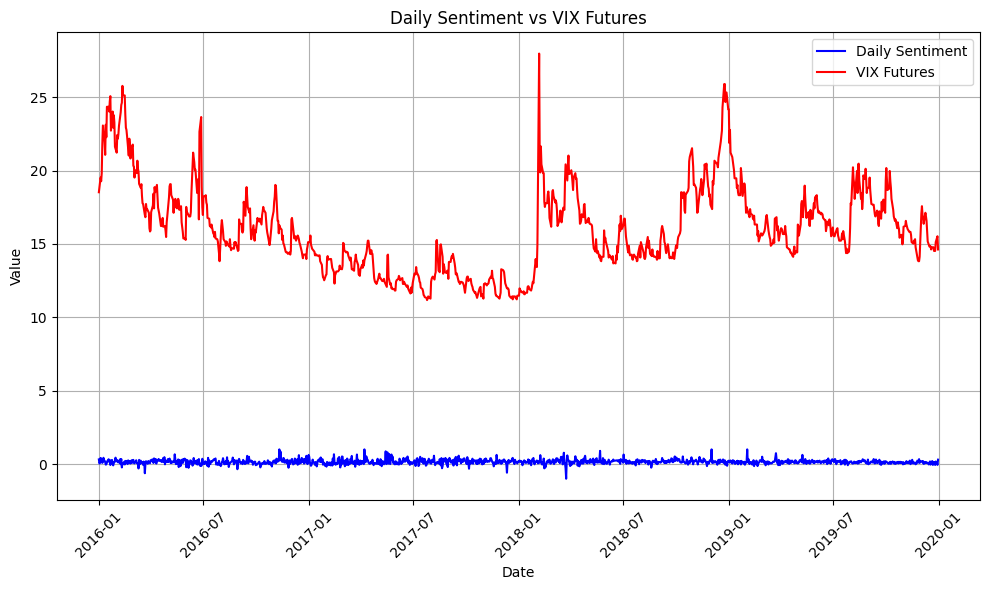

In [201]:
import matplotlib.pyplot as plt

vix_data = pd.read_excel('VIX_futures_2016_2019.xlsx')

vix_data['date'] = vix_data['Code']

# Convert date column to datetime
vix_data['date'] = pd.to_datetime(vix_data['date'])
vix_data['Code'] = pd.to_datetime(vix_data['Code'])

# Set date column as index
vix_data.set_index('date', inplace=True)

# Plotting
plt.figure(figsize=(10, 6))

# Plot daily sentiment
plt.plot(daily_average_sentiment['date'], daily_average_sentiment['sentiment'], color='blue', label='Daily Sentiment')

# Plot VIX futures values
plt.plot(vix_data.index, vix_data['Sett_price'], color='red', label='VIX Futures')

# #VIX futures adjusted so at max price of VIX, it is 1 and -1 at its minimum price
# vix_data['Sett_price'] = (vix_data['Sett_price'] - vix_data['Sett_price'].min()) / (vix_data['Sett_price'].max() - vix_data['Sett_price'].min()) * 2 - 1

# # Plot VIX futures values
# plt.plot(vix_data.index, vix_data['Sett_price'], color='green', label='VIX Futures adjusted')

# Formatting
plt.title('Daily Sentiment vs VIX Futures')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

There seems to be no visible relationship between over the period between the tweets and price of VIX futures.

### Constructing Strategy
---
Using two moving averages of daily sentiment where the first one is 30-day (longterm) and the other is 5 days (short term) rolling average.

If the short-term component is below the long-term component, then we take a long position and a short position otherwise.

In [202]:

# Compute long-term (30-day) and short-term (5-day) moving averages of daily sentiment
daily_average_sentiment['long_term_ma'] = daily_average_sentiment['sentiment'].rolling(window=30, min_periods=1).mean()
daily_average_sentiment['short_term_ma'] = daily_average_sentiment['sentiment'].rolling(window=5, min_periods=1).mean()


# Determine positions based on moving averages
daily_average_sentiment['position'] = 'Neutral'
daily_average_sentiment.loc[daily_average_sentiment['short_term_ma'] < daily_average_sentiment['long_term_ma'], 'position'] = 'Long'
daily_average_sentiment.loc[daily_average_sentiment['short_term_ma'] > daily_average_sentiment['long_term_ma'], 'position'] = 'Short'

# Display the positions
print(daily_average_sentiment[['date', 'position', 'short_term_ma', 'long_term_ma']])

            date position  short_term_ma  long_term_ma
0     2016-01-01  Neutral       0.315730      0.315730
1     2016-01-02  Neutral       0.176142      0.176142
2     2016-01-03  Neutral       0.150822      0.150822
3     2016-01-04  Neutral       0.217023      0.217023
4     2016-01-05  Neutral       0.246384      0.246384
...          ...      ...            ...           ...
1433  2019-12-27     Long       0.090748      0.106980
1434  2019-12-28     Long       0.091792      0.098867
1435  2019-12-29     Long       0.082282      0.098899
1436  2019-12-30     Long       0.044588      0.091406
1437  2019-12-31    Short       0.117293      0.095073

[1438 rows x 4 columns]


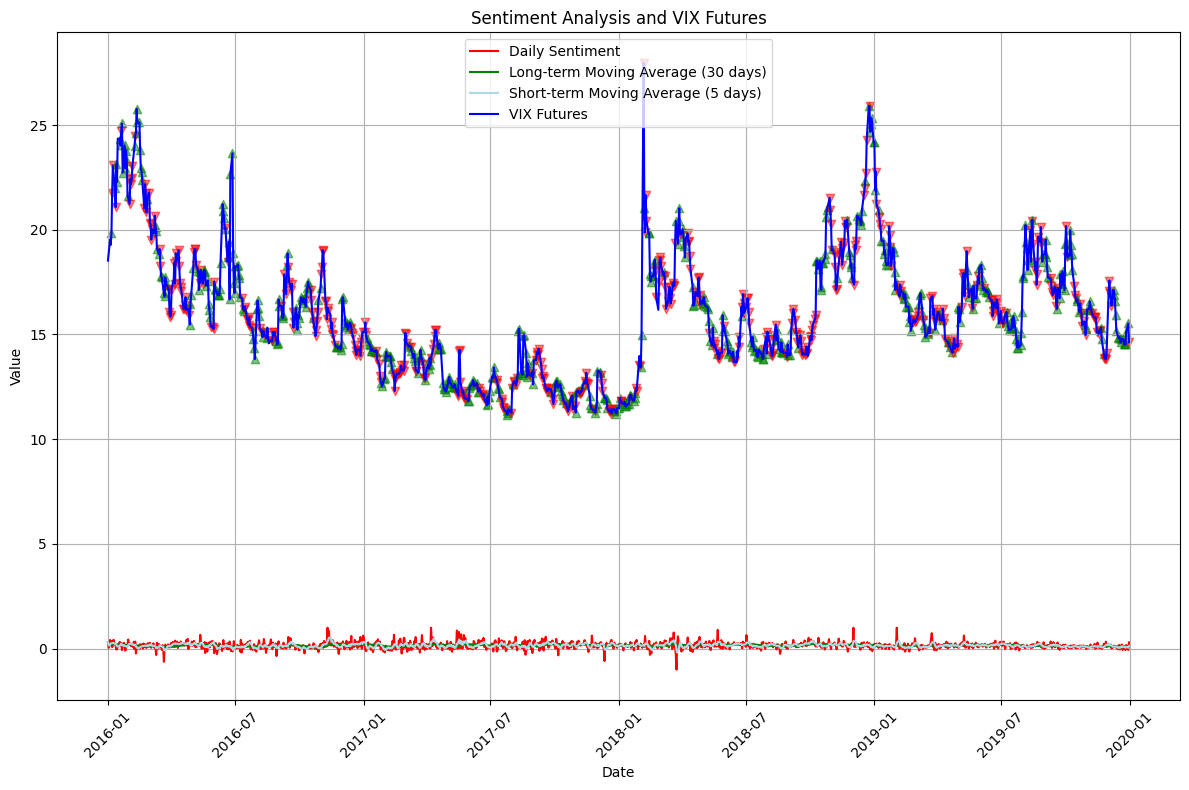

In [203]:
daily_average_sentiment['date'] = pd.to_datetime(daily_average_sentiment['date'])

# Plotting
plt.figure(figsize=(12, 8))

# Plot daily sentiment
plt.plot(daily_average_sentiment['date'], daily_average_sentiment['sentiment'], color='red', label='Daily Sentiment')

# Plot long-term and short-term moving averages
plt.plot(daily_average_sentiment['date'], daily_average_sentiment['long_term_ma'], color='green', label='Long-term Moving Average (30 days)')
plt.plot(daily_average_sentiment['date'], daily_average_sentiment['short_term_ma'], color='lightblue', label='Short-term Moving Average (5 days)')

# Plot VIX futures values
plt.plot(vix_data.index, vix_data['Sett_price'], color='blue', label='VIX Futures')

# Plot positions
for index, row in daily_average_sentiment.iterrows():
    if row['date'].strftime('%Y-%m-%d') in vix_data.index:
        if row['position'] == 'Long':
            plt.scatter(row['date'], vix_data.loc[row['date'], 'Sett_price'], color='green', alpha=0.5, marker='^')
        elif row['position'] == 'Short':
            plt.scatter(row['date'], vix_data.loc[row['date'], 'Sett_price'], color='red', alpha=0.5, marker='v')

# Formatting
plt.title('Sentiment Analysis and VIX Futures')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

This seems to be a very mixed indicator as there are several correct trades taken peaks and lows and several wrong indicators as well but overall, this seems to be an overall good indicator and reversing it would be a bad idea. 

### Computing average return, standard deviation and Sharpe ratio
---

In [205]:
# Merge sentiment data with VIX futures data to ensure alignment
merged_data = vix_data.merge(daily_average_sentiment, how='left', right_on='date', left_on='Code')

print(merged_data)

# Forward fill missing sentiment values
merged_data['position'] = merged_data['position'].fillna(method='ffill')

# Compute daily returns of the strategy
merged_data['strategy_return'] = merged_data['Sett_price'].pct_change() * merged_data['position'].map({'Long': 1, 'Short': -1, 'Neutral': 0})

# Filter data for the period from January 1, 2016, to December 31, 2018
start_date = '2016-01-01'
end_date = '2018-12-31'
pd.to_datetime(start_date)
pd.to_datetime(end_date)
merged_data = merged_data.loc[(merged_data.index >= start_date) & (merged_data.index <= end_date)]

# Compute cumulative returns of the strategy
merged_data['cumulative_return'] = (1 + merged_data['strategy_return']).cumprod()

# Calculate average return and standard deviation
average_return = merged_data['strategy_return'].mean()
std_deviation = merged_data['strategy_return'].std()

# Calculate Sharpe ratio (assuming zero risk-free rate)
sharpe_ratio = average_return / std_deviation

# Calculate drawdown
merged_data['previous_peaks'] = merged_data['cumulative_return'].cummax()
merged_data['drawdown'] = (merged_data['cumulative_return'] - merged_data['previous_peaks']) / merged_data['previous_peaks']

# Plot the evolution of $1,000 invested in the strategy
plt.figure(figsize=(12, 8))
plt.plot(merged_data.index, 1000 * merged_data['cumulative_return'], color='blue', label='Strategy')
plt.title('Evolution of $1,000 Invested in the Strategy')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print statistics
print(f"Average Return: {average_return:.4f}")
print(f"Standard Deviation: {std_deviation:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Maximum Drawdown: {merged_data['drawdown'].min():.4f}")

datetime64[ns]
datetime64[ns]


C:\Users\PeePeePoopoo\AppData\Local\Temp\ipykernel_26044\217165187.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data['position'] = merged_data['position'].fillna(method='ffill')


TypeError: Invalid comparison between dtype=int64 and str